In [125]:
# Import Modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import re

In [126]:
# Data Paths
data_dir = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/"
plot_dir = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Jun14"
# Ensure both directories exist
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
raw_data_path = os.path.join(data_dir, "RadiationAndANN_DATA_2021-11-15_0835.csv")
out_data_path = os.path.join(data_dir, "RadiationAndANN_DATA_2021-11-15_0835_data_exploration.csv")
dictionary_path = os.path.join(data_dir, "RadiationAndANN_DataDictionary_2021-11-15.csv")

In [127]:
# Global Variables 
susp_LN_present_composite_cols = [
        'abnormal_lymph',  # Ultrasound
        'prominent_axillary_lymph',  # Mammography
        'axillary_lymphadenopathy',  # MRI
        'internal_mammary_lymphaden',  # MRI
        'axillary_lymphadenopathy_p',
        'int_mammary_lymphade_pet'
        ]
susp_LN_max_size_composite_cols = [
    'lymph_node_max_size_mm',
    'lymph_node_max_size_mm0',
    'axillary_lymph_node_max_si',
    'internal_mammary_lymph_nod'
    ]

PRE_tumor_max_size_composite_cols = [
        "img_size",  # Ultrasound, in MM
        "tumor_size_mm",  # Mammography, in MM
        "size_of_the_largest_foci_c",  # PET, in CM
]

# intra_cols = [
#         'surgical_indication1_primary_treatment','laterality',
#         'surgery_date','breast_procedure', 
#         'axillary_surgery', 
#         'lymph_nodes','sln'
# ]

# post_cols = [

# ]
post_nodal_cols = ['metastasis', 'ln_w_micrometastasis', 'ln_w_macrometastasis', 'size_of_largest_nodal_meta', 'extranodal_extension', 'extent_of_extranodal_exten']

In [128]:
# Load Data
df = pd.read_csv(raw_data_path)
# Convert the unit of "size_of_the_largest_foci_c" column from CM into MM, if it is not already in MM
df["size_of_the_largest_foci_c"] = df["size_of_the_largest_foci_c"] * 10
df.head()

,record_id,dob,men_status,fmhx,gensus___1,gensus___2,gensus___3,gensus___4,gensus___5,gensus___6,...,dis_closest_margin,metastasis,ln_w_micrometastasis,ln_w_macrometastasis,size_of_largest_nodal_meta,extranodal_extension,extent_of_extranodal_exten,did_the_patient_receive_pm,did_the_patient_reject_pmr,data_collection_fields_complete
0,ANN001,10/1/60,2.0,0.0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2
1,ANN002,1/1/66,2.0,0.0,0,0,0,0,0,1,...,> 10,2.0,NaN,NaN,NaN,2.0,NaN,0.0,NaN,2
2,ANN003,6/1/62,2.0,0.0,0,0,0,0,0,1,...,1,2.0,NaN,NaN,NaN,2.0,NaN,0.0,NaN,2
3,ANN004,11/1/60,2.0,1.0,1,0,0,0,0,0,...,3,2.0,NaN,NaN,NaN,2.0,NaN,0.0,NaN,2
4,ANN005,10/1/59,2.0,0.0,0,0,0,0,0,1,...,NaN,1.0,0.0,1.0,5,1.0,NaN,1.0,NaN,2


In [129]:
# Load Data Dictionary
dictionary = pd.read_csv(dictionary_path)
# Rename "Variable / Field Name" to "Variable" column
dictionary.rename(columns={'Variable / Field Name': 'Variable'}, inplace=True)
# Rename "Choices, Calculations, OR Slider Labels" to "Options"
dictionary.rename(columns={'Choices, Calculations, OR Slider Labels': 'Options'}, inplace=True)
# Rename "Field Type" to "Type" 
dictionary.rename(columns={'Field Type': 'Type'}, inplace=True)
# Rename "Field Label" to "Label"
dictionary.rename(columns={'Field Label': 'Label'}, inplace=True)
# For the column "Section Header", replace NaN with the previous non-NaN value
dictionary["Section Header"].fillna(method='ffill', inplace=True)
# Rename "Section Header" to "Section"
dictionary.rename(columns={'Section Header': 'Section'}, inplace=True)
dictionary.head(10)

,Variable,Form Name,Section,Type,Label,Options,Field Note,Text Validation Type OR Show Slider Number,Text Validation Min,Text Validation Max,Identifier?,Branching Logic (Show field only if...),Required Field?,Custom Alignment,Question Number (surveys only),Matrix Group Name,Matrix Ranking?,Field Annotation
0,record_id,data_collection_fields,NaN,text,Record ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dob,data_collection_fields,Demographics,text,Date of Birth,NaN,NaN,date_ymd,NaN,NaN,NaN,NaN,y,NaN,NaN,NaN,NaN,NaN
2,men_status,data_collection_fields,Demographics,radio,Menopausal status,"0, pre-menopausal | 1, peri-menopausal | 2, po...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,fmhx,data_collection_fields,Demographics,yesno,Family History,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,gensus,data_collection_fields,Demographics,checkbox,Genetic Susceptibility,"1, BRCA1 | 2, BRCA2 | 3, p53 | 4, pten | 5, Ot...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,systhe,data_collection_fields,Demographics,checkbox,Pre-operative Systemic Therapy (Neoadjuvant),"1, Chemotherapy | 2, Hormonal therapy | 3, Bot...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,tumor_laterality,data_collection_fields,Demographics,radio,Tumor laterality,"1, right | 2, left | 3, bilateral",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,height_cm,data_collection_fields,Demographics,text,Height (cm),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,weight_kg,data_collection_fields,Demographics,text,Weight (kg),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,bra_cup_size,data_collection_fields,Demographics,text,Bra cup size,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
# A Helper function to save the plot to a file
def save_plot(plot_name):
    plot_path = os.path.join(plot_dir, plot_name)
    # Make plot background white
    # Show the plot and save
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    # Increase the plot size for saving
    plt.gcf().set_size_inches(20, 10)
    plt.savefig(plot_path, bbox_inches='tight', facecolor='white')
    print("Saved plot to: {}".format(plot_path))
    # Set the plot size back to normal
    plt.gcf().set_size_inches(10, 5)

Value counts for PRE_susp_LN_prsnt_composite:
0.0    576
1.0    174
dtype: int64


,abnormal_lymph,prominent_axillary_lymph,axillary_lymphadenopathy,internal_mammary_lymphaden,axillary_lymphadenopathy_p,int_mammary_lymphade_pet,0
0,1.0,NaN,NaN,NaN,1.0,0.0,1.0
1,0.0,NaN,NaN,NaN,NaN,NaN,0.0
2,NaN,NaN,0.0,0.0,NaN,NaN,0.0
3,0.0,0.0,NaN,NaN,NaN,NaN,0.0
4,0.0,0.0,NaN,NaN,NaN,NaN,0.0


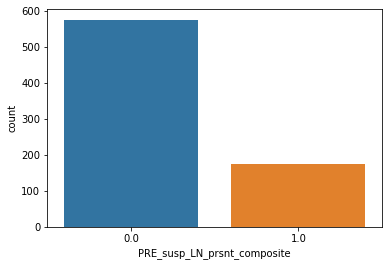

In [131]:
# Construct composite features for PRE Lymph Node Abnormality Presence
# Replace 3 (not mentioned) and 2 (No) with 0 (negative) for the PRE_susp_LN_prsnt_composite columns
for col in susp_LN_present_composite_cols:
    df[col] = df[col].replace(3, 0).replace(2, 0)
susp_LN_present_composite = df[susp_LN_present_composite_cols].max(axis=1, numeric_only=True)
# Add the composite feature to the dataframe, insert at the first position of source cols
idx = df.columns.get_loc(susp_LN_present_composite_cols[0])
# Insert if it doesn't exist
if "PRE_susp_LN_prsnt_composite" not in df.columns:
    df.insert(idx, "PRE_susp_LN_prsnt_composite", susp_LN_present_composite)
# Check results
print("Value counts for PRE_susp_LN_prsnt_composite:")
print(susp_LN_present_composite.value_counts())
# Plot the distribution of the PRE_susp_LN_prsnt_composite
sns.countplot(x="PRE_susp_LN_prsnt_composite", data=df)
pd.concat([df[susp_LN_present_composite_cols], susp_LN_present_composite], axis=1).head()

In [132]:
# Construct composite features for PRE Lymph Node Abnormality Size
susp_LN_max_size_composite = df[susp_LN_max_size_composite_cols].max(axis=1, numeric_only=True)
# Add the composite feature to the dataframe, insert at the first position of source cols
idx = df.columns.get_loc(susp_LN_max_size_composite_cols[0])
# Insert if it doesn't exist
if "PRE_susp_LN_max_size_composite" not in df.columns:
    df.insert(idx, "PRE_susp_LN_max_size_composite", susp_LN_max_size_composite)
# Check results - Plot the column with sorted values 
print("Value counts for PRE_susp_LN_max_size_composite:")
susp_LN_max_size_composite.value_counts().sort_index()
# Make a histogram of the column, with bins of 50
susp_LN_max_size_composite.hist(bins=50)
# Mark the axis and median value 
plt.axvline(susp_LN_max_size_composite.median(), color="r", linestyle="--")
plt.title("PRE_susp_LN_max_size_composite")
plt.xlabel("Size of Lymph Node in mm")
plt.ylabel("Frequency")
save_plot("PRE_susp_LN_max_size_composite.png")
# plt.show()

Value counts for PRE_susp_LN_max_size_composite:
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Jun14/PRE_susp_LN_max_size_composite.png


In [133]:
# Construct composite features for PRE Tumor Size
PRE_tumor_max_size_composite = df[PRE_tumor_max_size_composite_cols].max(axis=1, numeric_only=True)
# Add the composite feature to the dataframe, insert at the first position of source cols
idx = df.columns.get_loc(PRE_tumor_max_size_composite_cols[0])
# Insert if it doesn't exist
if "PRE_tumor_max_size_composite" not in df.columns:
    df.insert(idx, "PRE_tumor_max_size_composite", PRE_tumor_max_size_composite)
# Check results - Plot the column with sorted values 
print("Value counts for PRE_tumor_max_size_composite:")
# Make a histogram of the column, with bins of 50
PRE_tumor_max_size_composite.hist(bins=50)
# Mark the axis and median value
plt.axvline(PRE_tumor_max_size_composite.median(), color="r", linestyle="--")
plt.title("PRE_tumor_max_size_composite")
plt.xlabel("Size of Tumor in mm")
plt.ylabel("Frequency")
save_plot("PRE_tumor_max_size_composite.png")

Value counts for PRE_tumor_max_size_composite:
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Jun14/PRE_tumor_max_size_composite.png


--------------------------------------------------
Plotting distribution of metastasis for PRE composite features
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Jun14/PRE_susp_LN_prsnt_composite_vs_metastasis_Post_op.png
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Jun14/PRE_susp_LN_max_size_composite_vs_metastasis_Post_op.png
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Jun14/PRE_tumor_max_size_composite_vs_metastasis_Post_op.png
--------------------------------------------------
Plotting distribution of ln_w_micrometastasis for PRE composite features
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Jun14/PRE_susp_LN_prsnt_composite_vs_ln_w_micrometastasis_Post_op.png
Saved plot to: /Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/manual_review/plots_Jun14/PRE_susp_LN_max_size_composite_vs_ln_w_mic

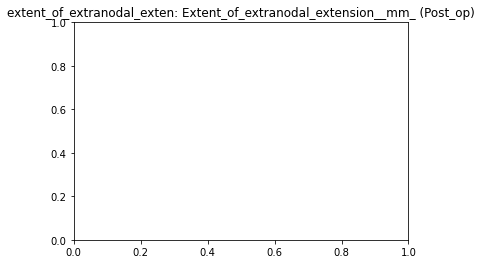

In [141]:
# Explore and visualize the relationship between the PRE composite features and the post nodal columns
# For each post nodal column, plot the distribution of the PRE composite features

pre_composite_cols = ["PRE_susp_LN_prsnt_composite", "PRE_susp_LN_max_size_composite", "PRE_tumor_max_size_composite"]

for post_col in post_nodal_cols:
    print("-"*50)
    print("Plotting distribution of {} for PRE composite features".format(post_col))
    for pre_col in pre_composite_cols:
        # Plot the distribution of the PRE composite features for the post nodal column
        # Using dictionary, depending on the type of the column, use different plotting functions
        definition = dictionary[dictionary["Variable"] == post_col]
        section = definition["Section"].iloc[0]
        section = section[:min(len(section), 7)]
        dtype = definition["Type"].iloc[0]  # radio, checkbox, text, yesno
        label = definition["Label"].iloc[0]
        options = definition["Options"].iloc[0]
        # Replace special characters and symbols in section and label using regex
        section = re.sub(r'[^\w]', '_', section)
        label = re.sub(r'[^\w]', '_', label)
        if str(options) != "nan":
            options = {int(x.split(",")[0].strip()) : x.split(",")[1].strip() for x in options.split("|")}
        else:
            options = {}

        # plt.title(f"{post_col}: {label} ({section})")
        # # Use charts to show the frequency of the pre_col with respect to the post_col
        # if dtype == "radio" or dtype == "checkbox" or "yesno":
        #     # The x-axis will be the pre_col values, and the y-axis will be the frequency of the pre_col
        #     plt.figure(figsize=(10, 5))
        #     plt.ylabel(f"Frequency of {post_col} ({label})")
        #     plt.xlabel(f"{pre_col}")
        #     plt.hist(df[pre_col], bins=50, alpha=0.5, label=post_col)
        # # elif dtype == "text":
        # #     # Plot using a scatter plot
        # #     # The x-axis will be the pre_col values, and the y-axis will be the value of the post_col
        # #     plt.figure(figsize=(10, 5))
        # #     plt.xlabel(f"{label}")
        # #     plt.ylabel(f"Value of {post_col}")
        # #     plt.scatter(df[pre_col], df[post_col])
        # else:
        #     print("Unknown type: {}".format(dtype))
        # # Make the legend with options
        # # if len(options) > 0:
        # #     plt.legend(list(options.values()))
        # plot_name = f"{pre_col}_vs_{post_col}_{section}"
        # save_plot(f"{plot_name}.png")
        # # plt.show()
        # plt.close()
